In [ ]:
from beexai.dataset.dataset import Dataset
from beexai.explanation.explaining import CaptumExplainer
from beexai.evaluate.metrics.get_results import get_all_metrics

In [68]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.inspection import permutation_importance

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


# Load TabNet

In [69]:
retrain = False

data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]
df_select_features.columns = ["RNA", "CSF", "DNA", "MRIth"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [70]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [71]:
with open("../pickle/training_2_dict_results.pickle", "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [72]:
if retrain : 
    tabnet_model =  TabNetModelWrapper(n_a=8, n_d=8)#   XGBoostRegressor() #  TabNetModelWrapper(n_a=8, n_d=8)
else :  
    tabnet_model = all_dict_results[9]["model"] # Corresponds to TabNet trained in notebook #3  

continuous_model  = imputer = KNNImputer(n_neighbors=5)
name_continuous_imputer  = "KNNImputer_5"
ordinal_model =  KNNImputer(n_neighbors=1)
name_ordinal_imputer = "KNNImputer"
name_model = "TabNetRegressor" # "XGBoostRegressor"#  "TabNetRegressor"

In [73]:
ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

# Separate imputers for ordinal and continuous data
print("Using separate imputers for ordinal and continuous data.")

df_X_train = df_X_train.copy()
df_X_test = df_X_test.copy()

for col in ordinal_features:
    df_X_train[col] = df_X_train[col].astype("category")
    df_X_test[col] = df_X_test[col].astype("category")

# Continuous Imputation Transformer (Example: SimpleImputer)
continuous_imputer = Pipeline([
    (name_continuous_imputer, continuous_model),
])

# Ordinal Imputation Transformer (Example: KNN Imputer)
ordinal_imputer = Pipeline([
    (name_ordinal_imputer, ordinal_model)
])

# Create a ColumnTransformer to apply the appropriate imputer to each type of variable
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_imputer, ordinal_features),
        ('continuous', continuous_imputer, continuous_features)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

    # Separate imputers for ordinal and continuous data

# Fit and transform, then convert back to DataFrame with original column names
start = time.time()
pipeline.fit(df_X_train)
end = time.time()

impute_model_time = end - start

X_train_imputed = pipeline.transform(df_X_train)
df_X_train_imputed = df_X_train.copy()
df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

# Transform the test set
if df_X_test.isna().any().any(): 
    X_test_imputed = pipeline.transform(df_X_test)
    df_X_test_imputed = df_X_test.copy()
    df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
else : 
    print("No NaN in test data -> Keep as it is. ")
    df_X_test_imputed = df_X_test

df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category", errors='ignore')
df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category", errors='ignore')

# Demographics adjustment for y
demographic_adjustment_y = DemographicAdjustmentTransformer()

y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

# Demographics adjustment for X
demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

# Standardize only continuous features
scaler = StandardScaler()

X_train_adjusted[continuous_features] = scaler.fit_transform(X_train_adjusted[continuous_features])
X_test_adjusted[continuous_features] = scaler.transform(X_test_adjusted[continuous_features])

if retrain: 
    # Perform prediction and save variables
    start = time.time()
    tabnet_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start
    print("Training time: ", end - start)
else : 
    predict_model_time = None

y_pred_adjusted = tabnet_model.predict(X_test_adjusted)

y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p

if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }
    
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted.values, 
        "y_test": y_test_adjusted.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


dict_results = {
    "params": params, 
    "imputation_time": impute_model_time,
    "fitting_time": predict_model_time, 
    "results_adj": results_adj, 
    "results_org": results_org
    }

Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Saving predictions in dict!


In [74]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

Domain: ADNI_MEM, Pearson correlation: 0.678, Pearson p-value: 0.011, MAE: 0.677
Domain: ADNI_EF, Pearson correlation: 0.722, Pearson p-value: 0.005, MAE: 0.633
Domain: ADNI_VS, Pearson correlation: 0.553, Pearson p-value: 0.050, MAE: 0.473
Domain: ADNI_LAN, Pearson correlation: 0.556, Pearson p-value: 0.049, MAE: 0.749


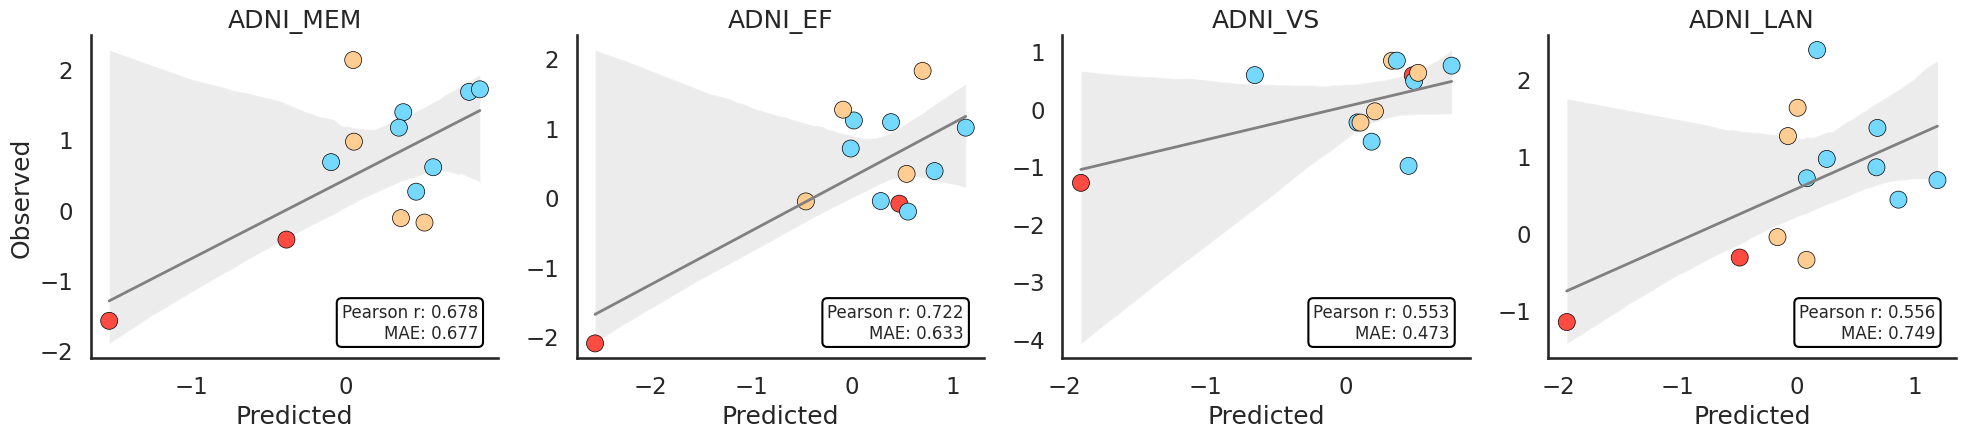

In [75]:
# Set style with no grid and larger context
sns.set_style("white")
sns.set_context("talk")  # Larger font sizes

# Create the lmplot without scatter points and no title
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # No scatter points from lmplot
    line_kws={"color": "grey", "lw": 2},
    legend=False  # No legend from lmplot
)

# Overlay scatter points with large size and annotations
cognitive_domains_order = g.col_names

for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]

    # Scatter points
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=150,  # Bigger scatter points
        edgecolor='black',  # Optional for clarity
        linewidth=0.5,
        legend=False  # No legend from scatterplot
    )
    
    # Legend styling
    ax.legend(loc="upper left", title="Diagnosis", fontsize=12, title_fontsize=13)
    
    # Metrics
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])

    print(f"Domain: {cognitive_domain}, Pearson correlation: {pearsonr(group_data['y_pred'], group_data['y_test'])[0]:.3f}, Pearson p-value: {pearsonr(group_data['y_pred'], group_data['y_test'])[1]:.3f}, MAE: {mae:.3f}")
    
    # Annotation
    ax.text(
        0.95, 0.05,
        f"Pearson r: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax.legend_.remove()  # Remove legend from each subplot

# Axis labels
g.set_axis_labels("Predicted", "Observed")
g.set_titles("{col_name}")  # Removes subtitle formatting

# Remove the main title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("")  # Set to empty to remove title

# Final layout cleanup
sns.despine()
plt.tight_layout()
plt.show()


# BeeXAI

In [ ]:
from beexai import BEE

bee = BEE(
    model=tabnet_model.model.network,   # actual torch model
    data=df_X_train_imputed,                        # pandas DataFrame
    labels=df_y_test_ajd,                      # or Series or ndarray
    model_type="regressor",          # important
    task="regression",               # or "multitask" if needed
    framework="pytorch"              # or "torch"
)

ModuleNotFoundError: No module named 'beexai.beexai'

# Captum

In [56]:
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, LayerConductance
from captum.attr import visualization as viz


In [61]:
X = torch.tensor(X_test_adjusted.values, dtype=torch.float32)
y = torch.tensor(df_y_test.values, dtype=torch.float32)

In [103]:
import torch
from captum.attr import (
    FeatureAblation, FeaturePermutation, Occlusion, ShapleyValueSampling
)

def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
) -> dict:
    """
    Compute perturbation-based attributions for a selected output in a multi-output model.

    Args:
        model_predict: callable numpy-output predictor, shape (N, D)
        X: torch.Tensor of shape (N, F)
        output_idx: which output dimension to explain
        shapley_samples: number of samples for ShapleyValueSampling

    Returns:
        dict of attribution tensors, e.g., {'ablation': Tensor(N,F), ...}
    """
    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    attrs = {}
    attrs['ablation'] = FeatureAblation(forward_i).attribute(X, baselines=0)
    attrs['permutation'] = FeaturePermutation(forward_i).attribute(X)
    attrs['occlusion'] = Occlusion(forward_i).attribute(X, baselines=0, sliding_window_shapes=(1,))
    attrs['shapley'] = ShapleyValueSampling(forward_i).attribute(X, baselines=0, n_samples=shapley_samples)

    return attrs


In [ ]:
def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
) -> dict:
    """
    Compute perturbation-based attributions for a selected output in a multi-output model.

    Args:
        model_predict: callable numpy-output predictor, shape (N, D)
        X: torch.Tensor of shape (N, F)
        output_idx: which output dimension to explain
        shapley_samples: number of samples for ShapleyValueSampling

    Returns:
        dict of attribution tensors, e.g., {'ablation': Tensor(N,F), ...}
    """
    def forward_predict(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    explainers = {
        'ablation': FeatureAblation(forward_predict).attribute(X, baselines=0),
        'permutation': FeaturePermutation(forward_predict).attribute(X),
        'occlusion': Occlusion(forward_predict).attribute(X, baselines=0, sliding_window_shapes=(1,)),
        'shapley': ShapleyValueSampling(forward_predict).attribute(X, baselines=0, n_samples=shapley_samples)
    }

    return explainers, forward_predict

In [139]:
X_test_tensor = torch.tensor(X_test_adjusted.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_adjusted.values, dtype=torch.float32)

model_predict = tabnet_model.predict  # your numpy-based predictor

explainers, forward_i = compute_perturbation_attrs(
    model_predict, X_train_tensor, output_idx=0, shapley_samples=50
)

In [ ]:
df = pd.DataFrame()
for key, attr in explainers.items():
    print(f"{key} shape: {attr.shape}")
    df[key] = attr.numpy().mean(axis=0)

ablation shape: torch.Size([2881, 256])
permutation shape: torch.Size([2881, 256])
occlusion shape: torch.Size([2881, 256])
shapley shape: torch.Size([2881, 256])


In [174]:
import torch
import pandas as pd
import numpy as np

def format_attrs_for_plot(explainers: dict, feature_names: list) -> pd.DataFrame:
    """
    Convert explainers dict to a DataFrame with columns:
    'method', 'feature', 'avg_abs_attr', 'std_abs_attr'.
    
    explainers: dict e.g. {'ablation': Tensor(N,F), ...}
    feature_names: list of length F
    """
    rows = []
    for method, tensor in explainers.items():
        arr = tensor.detach().cpu().numpy()  # shape (N, F)
        avg_abs = np.mean(np.abs(arr), axis=0)  # vector length F
        std_abs = np.std(np.abs(arr), axis=0)  # vector length F
        for feat_name, avg, std in zip(feature_names, avg_abs, std_abs):
            rows.append({
                'method': method,
                'feature': feat_name,
                'avg_abs_attr': avg,
                'std_abs_attr': std
            })
    return pd.DataFrame(rows)


In [175]:
df_attr = format_attrs_for_plot(explainers, X_train_adjusted.columns.tolist())

In [172]:
def topk_per_method(df_attr, k=10):
    """
    For each method, keep the top k features by avg_abs_attr.
    df_attr: DataFrame with columns ['method','feature','avg_abs_attr']
    """
    return (
        df_attr
        .groupby('method', group_keys=False)
        .apply(lambda g: g.nlargest(k, 'avg_abs_attr'))
        .reset_index(drop=True)
    )

df_top = topk_per_method(df_attr, k=30)


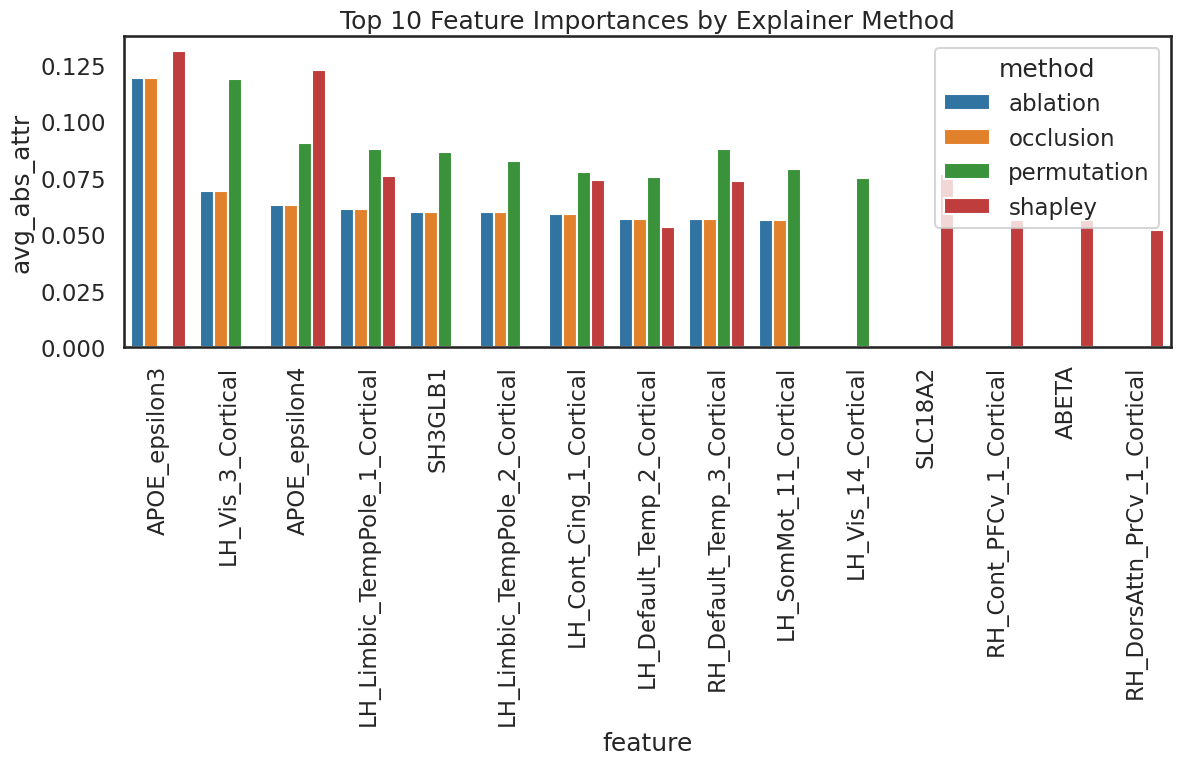

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_attr is the DataFrame returned by format_attrs_for_plot
df_attr['avg_abs_attr'] = df_attr['avg_abs_attr'].astype(float)
df_attr['std_abs_attr'] = df_attr['std_abs_attr'].astype(float)

# Group by 'method' and 'feature' to compute mean and std
df_grouped = df_attr.groupby(['method', 'feature']).agg(
    avg_abs_attr=('avg_abs_attr', 'mean'),
    std_abs_attr=('std_abs_attr', 'mean')
).reset_index()

# Rank features by 'avg_abs_attr' and select top N
top_n = 10
df_top_features = df_grouped.groupby('method').apply(
    lambda x: x.nlargest(top_n, 'avg_abs_attr')
).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_features,
    x='feature',
    y='avg_abs_attr',
    hue='method',
    ci=None
)
plt.xticks(rotation=90)
plt.title(f'Top {top_n} Feature Importances by Explainer Method')
plt.tight_layout()
plt.show()


In [152]:
from captum.metrics import infidelity, sensitivity_max
import torch

def compute_metrics(
    forward_func, X: torch.Tensor, attrs: dict, baselines: torch.Tensor,
    perturbation_samples: int = 50, sens_radius: float = 0.01
) -> dict:
    results = {}

    def perturb_func(inputs, baselines):
        noise = torch.randn_like(inputs) * sens_radius
        return noise, inputs + noise

    for name, attr in attrs.items():
        # Recompute attributions on perturbed inputs for sensitivity
        def explanation_fn(inp):
            return attr  # Use original as baseline for sensitivity comparison

        inf = infidelity(
            forward_func,
            perturb_func,
            X,
            attr,
            baselines=baselines,
            n_perturb_samples=perturbation_samples,
            normalize=True
        )
        sens = sensitivity_max(
            explanation_fn,
            X,
            perturb_radius=sens_radius,
            n_perturb_samples=perturbation_samples,
            norm_ord='fro'
        )

        results[name] = {'infidelity': inf.item(), 'sensitivity': sens.item()}

    return results


In [153]:
baselines = torch.zeros_like(X)

# Step 2: Compute infidelity and sensitivity metrics from attributions
metrics = compute_metrics(forward_i , X_train_tensor, explainers, baselines)


RuntimeError: The size of tensor a (12800) must match the size of tensor b (256) at non-singleton dimension 1

## Debug

In [ ]:
import torch
from captum.attr import (
    FeatureAblation, FeaturePermutation, Occlusion, ShapleyValueSampling
)
from captum.metrics import infidelity, sensitivity_max

def compute_perturbation_attrs_with_metrics(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100, perturbation_samples: int = 50
) -> dict:
    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    baselines = torch.zeros_like(X)

    results = {}
    explainers = {
        'ablation': FeatureAblation(forward_i).attribute(X, baselines=0),
        'permutation': FeaturePermutation(forward_i).attribute(X),
        'occlusion': Occlusion(forward_i).attribute(X, baselines=0, sliding_window_shapes=(1,)),
        'shapley': ShapleyValueSampling(forward_i).attribute(X, baselines=0, n_samples=shapley_samples)
    }

    for name, attr in explainers.items():
        # Compute metrics
        inf = infidelity(
            forward_i, 
            lambda inp: (None, inp + torch.randn_like(inp) * 0.01),
            X, attr, baselines=baselines, n_perturb_samples=perturbation_samples, normalize=True
        )
        sens = sensitivity_max(
            forward_i,
            X, attr,
            stdevs=0.01,
            n_perturb_samples=perturbation_samples,
            abs=False
        )
        results[name] = {'attr': attr, 'infidelity': inf.item(), 'sensitivity': sens.item()}

    return results


In [135]:
def compute_metrics_from_attr(model_predict, X: torch.Tensor, output_idx: int = 0, explainers: dict ={} , perturbation_samples: int = 50): 

    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    baselines = torch.zeros_like(X)

    results = {}
    
    for name, attr in explainers.items():
        # Compute metrics
        inf = infidelity(
            forward_i, 
            lambda inp: (None, inp + torch.randn_like(inp) * 0.01),
            X, attr, baselines=baselines, n_perturb_samples=perturbation_samples, normalize=True
        )
        sens = sensitivity_max(
            forward_i,
            X, attr,
            stdevs=0.01,
            n_perturb_samples=perturbation_samples,
            abs=False
        )
        results[name] = {'attr': attr, 'infidelity': inf.item(), 'sensitivity': sens.item()}

    return results